In [1]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
target = pd.read_csv('data/SampleSubmissionStage1.csv').set_index('ID').drop('Pred', axis=1)
target['Season'] = target.index.map(lambda i: i[:4])
target['team_a'] = target.index.map(lambda i: i[5:9])
target['team_b'] = target.index.map(lambda i: i[10:14])
target['in_target'] = True
target.sample()

,Season,team_a,team_b,in_target
ID,,,,
2014_1211_1417,2014,1211,1417,True


In [5]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
1057,2001,143,1181,76,1417,63,N,0,13


In [10]:
regular_games = pd.read_csv('data/RegularSeasonCompactResults.csv')
regular_games = regular_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
regular_games['diff'] = regular_games['WScore'] - regular_games['LScore']
print(regular_games.shape)
regular_games.sample()

(150684, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
105558,2009,75,1214,74,1354,60,H,0,14


In [101]:
data = cp.deepcopy(ncaa_games)
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win']]
data = pd.concat([data, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})

lags = 3
for team, opponent_team in [('a', 'b'), ('b','a')]:
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_season = regular_games\
        .groupby(['Season', 'WTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_season_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_season[
            'won_in_season_{}_lag-{}'.format(team, l)] = won_in_season[
            'won_in_season_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_season.drop('won_in_season_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_season,
                    left_on=['Season', 'team_{}'.format(team)], right_index=True,
                    how='left')
    
    
    # SEASON WINS AGAINST THE OPPONENT
    season_wins_against_opponent = regular_games.groupby(['Season', 'WTeamID', 'LTeamID']).sum()[['diff']]\
        .rename(columns={'diff': 'season_wins_against_opponent_{}'.format(team)}).fillna(0)
    for l in range(1, lags+1):
        season_wins_against_opponent['season_wins_against_opponent_{}_lag-{}'.format(team, l)] =\
            season_wins_against_opponent['season_wins_against_opponent_{}'.format(team)].shift(l)
    season_wins_against_opponent.drop('season_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, season_wins_against_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # AVERAGE DIFF TO OPPONENT IN THE SEASON
    average_win_diff = regular_games.groupby(['Season', 'WTeamID', 'LTeamID']).mean()[['diff']]\
        .rename(columns={'diff': 'average_win_diff_{}'.format(team)})
    for l in range(1, lags+1):
        average_win_diff[
            'average_win_diff_{}_lag-{}'.format(team, l)] = average_win_diff[
            'average_win_diff_{}'.format(team)
        ].shift(l).fillna(0)
    average_win_diff.drop('average_win_diff_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, average_win_diff,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_ncaa = ncaa_games\
        .groupby(['Season', 'WTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_ncaa_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_ncaa[
            'won_in_ncaa_{}_lag-{}'.format(team, l)] = won_in_ncaa[
            'won_in_ncaa_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_ncaa.drop('won_in_ncaa_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_ncaa,
                    left_on=['Season', 'team_{}'.format(team)], right_index=True,
                    how='left').fillna(0)
    
    # NCAA WINS AGAINST THE OPPONENT
#     ncaa_wins_against_opponent = ncaa_games.groupby(['Season', 'WTeamID', 'LTeamID']).sum()[['diff']]\
#         .rename(columns={'diff': 'ncaa_wins_against_opponent_{}'.format(team)}).sort_index()
#     for l in range(1, lags+1):
#         ncaa_wins_against_opponent['ncaa_wins_against_opponent_{}_lag-{}'.format(team, l)] =\
#             ncaa_wins_against_opponent['ncaa_wins_against_opponent_{}'.format(team)].shift(l).fillna(0)
#     ncaa_wins_against_opponent.drop('ncaa_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
#     data = pd.merge(data, ncaa_wins_against_opponent,
#                     left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
#                     right_index=True,
#                     how='left').fillna(0)
    
    
data = data.dropna()
data.head(5)

,Season,a_win,in_target,team_a,team_b,won_in_season_a_lag-1,won_in_season_a_lag-2,won_in_season_a_lag-3,season_wins_against_opponent_a_lag-1,season_wins_against_opponent_a_lag-2,...,won_in_season_b_lag-3,season_wins_against_opponent_b_lag-1,season_wins_against_opponent_b_lag-2,season_wins_against_opponent_b_lag-3,average_win_diff_b_lag-1,average_win_diff_b_lag-2,average_win_diff_b_lag-3,won_in_ncaa_b_lag-1,won_in_ncaa_b_lag-2,won_in_ncaa_b_lag-3
0,1985,True,False,1116,1234,17.0,11.0,18.0,0.0,0.0,...,15.0,29.0,13.0,10.0,29.0,13.0,5.0,0.0,0.0,0.0
1,1985,True,False,1120,1345,15.0,11.0,21.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,True,False,1207,1250,17.0,20.0,13.0,0.0,0.0,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,True,False,1229,1425,23.0,13.0,10.0,0.0,0.0,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,True,False,1242,1325,12.0,13.0,8.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
data.shape

(11229, 29)

In [103]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data[~data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y = data[~data.in_target.astype(bool)][['a_win']]

kf = KFold(n_splits=8, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    xgb = XGBClassifier()
    xgb.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = xgb.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.39414749772393337
0.4010617096376834
0.3341697829169274
0.35279274816396383
0.36718944017379984
0.3291041290212888
0.313451640272185
0.30203352735781774
Metric Mean: 0.35 (0.03)


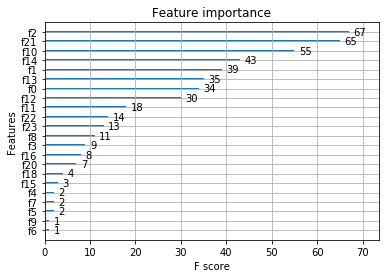

In [107]:
from xgboost import plot_importance

plot_importance(xgb, max_num_features=25)
plt.show()

In [108]:
X_sub = data[data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y_sub = data[data.in_target.astype(bool)][['Season', 'team_a', 'team_b', 'a_win', 'in_target']]

xgb = XGBClassifier()
xgb.fit(X.values, y.values.reshape(-1))
preds = xgb.predict_proba(X_sub.values)

sub = cp.deepcopy(y_sub)
sub['Pred'] = preds[:,1]
sub['ID'] = sub['Season'].map(str) + '_' + sub['team_a'].map(str) + '_' + sub['team_b'].map(str)
sub.set_index('ID', inplace=True)
sub.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1, inplace=True)
sub.head()

,Pred
ID,
2014_1107_1110,0.996477
2014_1107_1112,0.560625
2014_1107_1113,0.996240
2014_1107_1124,0.600747
2014_1107_1140,0.996477


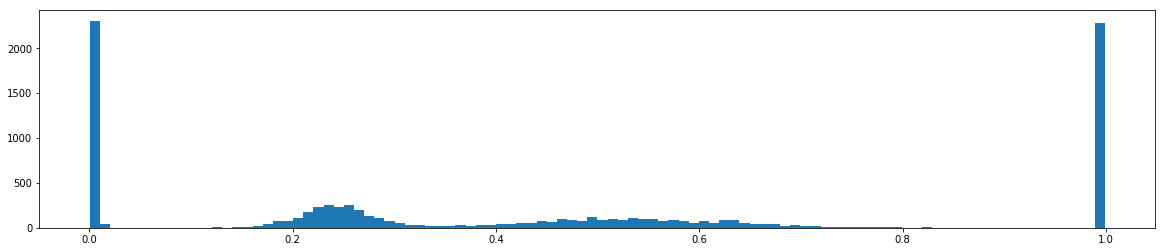

In [110]:
plt.figure(figsize=(20,4))
plt.hist(sub['Pred'], bins=100)
plt.show()

In [111]:
sub.to_csv('submissions/xgb_baseline_2.csv')